In [1]:
# data from https://sciendo.com/article/10.21307/joss-2019-012
# Heron Ziegel
# 915986142

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import mean_absolute_percentage_error

# Reads the data file into a DataFrame
df = pd.read_csv('../Data/CoW/imbalance.csv')

# Prints the first 5 rows of the DataFrame
print(df.head())

   Year  Imbalance
0  1946         26
1  1947         28
2  1948         32
3  1949         28
4  1950         22


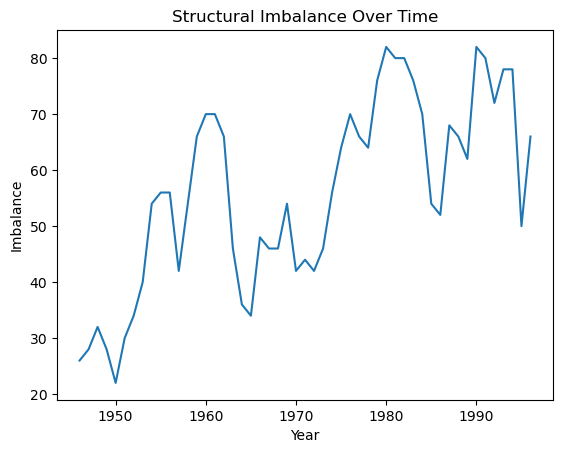

In [2]:
# Visualize the line graph

x = df['Year']
y = df['Imbalance']

plt.plot(x, y)
plt.xlabel("Year")
plt.ylabel("Imbalance")
plt.title("Structural Imbalance Over Time")
plt.show()

In [3]:
# Convert the imbalance data to a time series

timeseries = df[["Imbalance"]].values.astype('float32')
print("time series mean: ", df['Imbalance'].mean())

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

mean:  55.88235294117647


In [4]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [5]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([33, 1, 1]) torch.Size([33, 1, 1])
torch.Size([16, 1, 1]) torch.Size([16, 1, 1])


/var/folders/ty/5pt45c5s0nn0gmpld9mfvbz80000gn/T/ipykernel_26088/778121417.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  return torch.tensor(X), torch.tensor(y)


In [6]:
# Build LSTM model with output as tuple
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [7]:
# Train model
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 51.1182, test RMSE 70.0886
Epoch 100: train RMSE 30.6043, test RMSE 48.4038
Epoch 200: train RMSE 19.6803, test RMSE 35.3500
Epoch 300: train RMSE 14.0686, test RMSE 27.1019
Epoch 400: train RMSE 11.3006, test RMSE 21.7384
Epoch 500: train RMSE 9.7354, test RMSE 18.1952
Epoch 600: train RMSE 8.8845, test RMSE 15.7570
Epoch 700: train RMSE 8.4637, test RMSE 14.2422
Epoch 800: train RMSE 8.1394, test RMSE 13.5098
Epoch 900: train RMSE 8.0086, test RMSE 12.4536
Epoch 1000: train RMSE 7.9277, test RMSE 12.1393
Epoch 1100: train RMSE 8.2664, test RMSE 11.2526
Epoch 1200: train RMSE 7.9176, test RMSE 11.7242
Epoch 1300: train RMSE 7.8582, test RMSE 11.2090
Epoch 1400: train RMSE 7.8209, test RMSE 11.5856
Epoch 1500: train RMSE 7.9261, test RMSE 11.0613
Epoch 1600: train RMSE 7.8735, test RMSE 10.9949
Epoch 1700: train RMSE 7.8227, test RMSE 11.5068
Epoch 1800: train RMSE 8.3436, test RMSE 12.8782
Epoch 1900: train RMSE 7.8774, test RMSE 10.4789


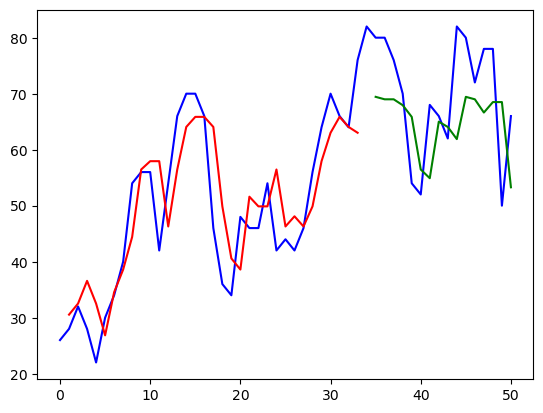

In [8]:
# Visualize prediction
# time series in blue, training results in red, testing in green

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [9]:
# Mean Absolute Percentage Error for the testing data
last_elements = (-1*len(y_test))
new_arr = y_pred.numpy()
arr = new_arr[last_elements:]
test_arr = y_test.numpy()
test_mape = mean_absolute_percentage_error(np.squeeze(test_arr), arr)

print(test_mape)

0.25719594955444336


In [33]:
# Grab data from last 10 years
df_trend = pd.read_csv('../Data/imbalance_trend.csv')

y_trend = df_trend['Imbalance']*100
x_trend = df_trend['Year']

print(y_trend)
print(x_trend)

0    86.666667
1    86.666667
2    86.666667
3    86.666667
4    86.666667
5    86.060606
6    84.242424
7    83.636364
8    83.636364
9    84.848485
Name: Imbalance, dtype: float64
0    2016
1    2017
2    2018
3    2019
4    2020
5    2021
6    2022
7    2023
8    2024
9    2025
Name: Year, dtype: int64


In [34]:
# Make new prediction

new_data_test = y_trend.to_numpy(dtype=np.float32).reshape(-1, 1)
torch_data_test = torch.from_numpy(new_data_test)

model.eval()

with torch.no_grad():
    y_pred_trend = model(torch_data_test)

print(y_pred_trend)

tensor([[70.2799],
        [80.6785],
        [82.5292],
        [82.9121],
        [83.0250],
        [82.9841],
        [82.7208],
        [82.6137],
        [82.6065],
        [82.8036]])


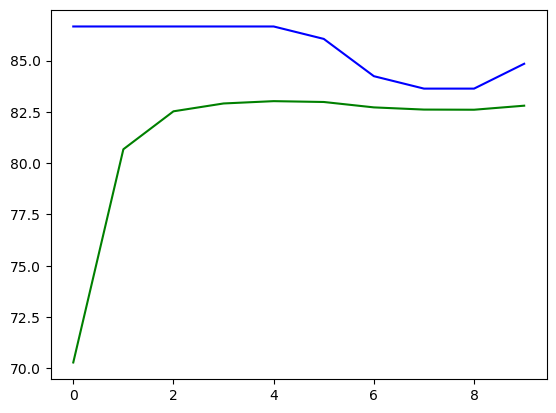

82.8035659790039


In [43]:
# Plot the new prediction

plt.plot(y_trend.to_numpy(), c='b')
plt.plot(y_pred_trend, c='g')
plt.show()

In [62]:
# Forecast the next few steps in the model
from sklearn.metrics import mean_squared_error

num_forecast_steps = 3
sequence_to_plot = torch_data_test.squeeze().cpu().numpy()
historical_data = sequence_to_plot

forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to('cpu')
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value


# Evaluate the model and calculate RMSE and R² score
model.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to('cpu').unsqueeze(0)  # Add batch dimension
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy().flatten(), test_predictions))
new_mape = mean_absolute_percentage_error(y_test.cpu().numpy().flatten(), test_predictions)

print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {new_mape:.4f}')

RMSE: 10.8162
MAPE: 0.1367


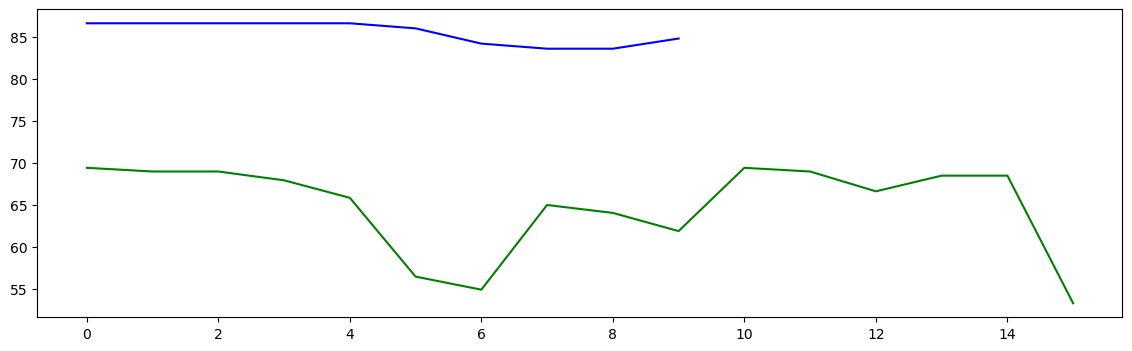

In [63]:
# Visualize the last steps with the earlier steps

plt.plot(y_trend.to_numpy(), c='b')
plt.plot(test_predictions, c='g')
plt.show()